In [1]:
import os, time, glob, socket
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
import pickle
path=os.getcwd()
pd.set_option("display.max_columns", None)

In [2]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Read Data

In [3]:
train = pd.read_csv("train.csv") 
test= pd.read_csv("test_no_G3.csv")

con_var=["age", "studytime", "failures", "famrel", "freetime", "goout", "Dalc", "Walc", "health", "absences"]
binary_var=["school","sex","famsize","activities","higher","internet","romantic"]

ID=['ID']
target=['G3']
train=train[ID+target+con_var+binary_var]
test=test[ID+con_var+binary_var]
print(train.shape)
print(test.shape)

(1000, 19)
(44, 18)


In [4]:
train.head()

,ID,G3,age,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school,sex,famsize,activities,higher,internet,romantic
0,1,18,16,2,0,4,3,2,1,1,3,0,GP,M,GT3,yes,yes,yes,yes
1,2,10,17,1,0,5,5,5,3,5,5,0,MS,M,GT3,yes,no,no,yes
2,3,11,17,3,0,4,2,2,2,3,5,10,GP,F,GT3,no,yes,yes,yes
3,4,8,16,2,0,3,4,3,2,3,3,10,GP,M,GT3,yes,yes,yes,no
4,5,16,15,2,0,4,5,2,1,1,5,0,GP,M,GT3,yes,yes,yes,yes


# Transform binary columns to one-hot encoding vectors

In [5]:
train=pd.concat([train[ID+target+con_var],pd.DataFrame(pd.get_dummies(train[binary_var]))],axis=1) 
test=pd.concat([test[ID+con_var],pd.DataFrame(pd.get_dummies(test[binary_var]))],axis=1) 

In [6]:
train.head()

,ID,G3,age,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_GP,school_MS,sex_F,sex_M,famsize_GT3,famsize_LE3,activities_no,activities_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,1,18,16,2,0,4,3,2,1,1,3,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1
1,2,10,17,1,0,5,5,5,3,5,5,0,0,1,0,1,1,0,0,1,1,0,1,0,0,1
2,3,11,17,3,0,4,2,2,2,3,5,10,1,0,1,0,1,0,1,0,0,1,0,1,0,1
3,4,8,16,2,0,3,4,3,2,3,3,10,1,0,0,1,1,0,0,1,0,1,0,1,1,0
4,5,16,15,2,0,4,5,2,1,1,5,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1


### (a)-1  Split train.csv into training set (80%) and validation set (20%)

In [7]:
def train_valid_split(train,p):
    SRS_index=random.sample(range(0,train.shape[0]),int(train.shape[0]*p))
    training_set=train[train.index.isin (SRS_index)]
    validation_set=train[~train.index.isin (SRS_index)]
    return(training_set,validation_set)    

In [8]:
random.seed(11)
p=0.8
training_set,validation_set=train_valid_split(train,p)

print(training_set.shape)
print(validation_set.shape)

(800, 26)
(200, 26)


### Please elaborate on how you obtain your training and test sets in your report.

#### <font color=blue> train 裡面總共有1000筆資料，index 從 0-999。利用簡單隨機抽樣，從0-999中隨機抽取(1000*0.8)個row， 當作 training set，其餘的row則為validation set </font>

### (a)-2 Normalization
Both the training and
validation set should be normalized by subtracting the (column-wise) means of training set
from them and then divided by the (column-wise) standard deviations of the training set.

In [9]:
tra_X_mean=training_set[training_set.columns[2:]].mean(axis=0) #選擇需要 normalized 的變數
tra_X_std=training_set[training_set.columns[2:]].std(axis=0)

# tra_Y_mean=training_set[target].mean(axis=0)
# tra_Y_std=training_set[target].std(axis=0)

In [10]:
def Normalization(training_set,validation_set,test,tra_X_mean,tra_X_std):
    training_set_N=training_set
    validation_set_N=validation_set
    test_N=test
    
    for i in range(0,len(tra_X_mean.index)):
        training_set_N[tra_X_mean.index[i]]=(training_set[tra_X_mean.index[i]]-tra_X_mean[i])/tra_X_std[i]
        validation_set_N[tra_X_mean.index[i]]=(validation_set[tra_X_mean.index[i]]-tra_X_mean[i])/tra_X_std[i]
        test_N[tra_X_mean.index[i]]=(test[tra_X_mean.index[i]]-tra_X_mean[i])/tra_X_std[i]

    return(training_set_N, validation_set_N,test_N)    

In [11]:
training_set_N, validation_set_N,test_N=Normalization(training_set,validation_set,test,tra_X_mean,tra_X_std)

In [52]:
# training_set_N[tra_Y_mean.index]=(training_set[tra_Y_mean.index]-tra_Y_mean)/tra_Y_std
# validation_set_N[tra_Y_mean.index]=(validation_set[tra_Y_mean.index]-tra_Y_mean)/tra_Y_std

In [12]:
training_set_N.head()

,ID,G3,age,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_GP,school_MS,sex_F,sex_M,famsize_GT3,famsize_LE3,activities_no,activities_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,1,18,-0.590675,0.011658,-0.392305,0.117200,-0.203092,-1.003039,-0.532798,-0.978107,-0.363853,-0.718383,0.588530,-0.588530,-1.150619,1.150619,0.646465,-0.646465,-1.017020,1.017020,-0.304598,0.304598,-0.530753,0.530753,-1.354468,1.354468
3,4,8,-0.590675,0.011658,-0.392305,-0.913132,0.769804,-0.141137,0.606877,0.605872,-0.363853,0.899597,0.588530,-0.588530,-1.150619,1.150619,0.646465,-0.646465,-1.017020,1.017020,-0.304598,0.304598,-0.530753,0.530753,0.737374,-0.737374
4,5,16,-1.397057,0.011658,-0.392305,0.117200,1.742700,-1.003039,-0.532798,-0.978107,1.025563,-0.718383,0.588530,-0.588530,-1.150619,1.150619,0.646465,-0.646465,-1.017020,1.017020,-0.304598,0.304598,-0.530753,0.530753,-1.354468,1.354468
5,6,10,1.828471,-1.154116,1.161379,0.117200,0.769804,0.720766,1.746552,0.605872,1.025563,-0.071191,-1.697024,1.697024,-1.150619,1.150619,0.646465,-0.646465,0.982036,-0.982036,-0.304598,0.304598,-0.530753,0.530753,0.737374,-0.737374
6,7,11,-1.397057,0.011658,-0.392305,1.147532,0.769804,-1.003039,1.746552,1.397861,1.025563,-0.718383,0.588530,-0.588530,-1.150619,1.150619,0.646465,-0.646465,0.982036,-0.982036,-0.304598,0.304598,-0.530753,0.530753,0.737374,-0.737374


### (b) (10%) Implement a linear regression model without the bias term to predict G3. Use pseudo_inverse to obtain the weights.   Record the root mean squared error (RMSE) of the test set ( validation_set ). 


$X^{+}=(X^{T}X)^{-1}X^{T}$
 
$\hat{w}_{pin}=X^{+}y$ 

$\hat{y}=\hat{w}_{pin}^{T}X$


In [13]:
# training set
X_train=np.concatenate(([np.matrix(training_set_N[training_set.columns[col]]).T 
                         for col in range(2,len(training_set.columns))]),axis=1)

y_train=np.matrix(training_set_N[target])

In [14]:
#  validation set

X_val=np.concatenate(([np.matrix(validation_set_N[validation_set_N.columns[col]]).T 
                       for col in range(2,len(validation_set_N.columns))]),axis=1)
y_val=np.asarray(validation_set[target]).reshape(-1)

In [15]:
def LR(X,Y):
    w=np.dot(np.linalg.pinv(X),Y)
    y_hat=np.matmul(X,w)
    return(w,y_hat)

$RMSE=\sqrt{\frac{1}{n}\sum^{i=1}_{n}{(y_i-\hat{y}_i)^{2}}}$

In [16]:
def RMSE(Y_true,Y_pred):
    Y_pred=np.asarray(Y_pred).reshape(-1)
    Y_true=np.asarray(Y_true).reshape(-1)
    rmse=np.sqrt(np.mean(np.square(Y_pred-Y_true)))
    return(rmse)

In [17]:
w,y_hat=LR(X_train,y_train)
y_pred_LR=np.matmul(X_val,w)

# RMSE

In [18]:
RMSE(y_val,y_pred_LR)

11.903739629313966

### (c)  Regularization for linear regression model , without the bias term

$J(w)=MSE_{train}+\frac{\lambda}{2}w^Tw$

$\hat{w}=\arg{min\left\{\,\sum_{i=1}^{N}(\,{y_i-w_0-\sum_{j=1}^{p}}x_{ij}w_j)^2+\frac{1}{2}\sum_{j=1}^{p}{w_j^2}\,\right\}}$ 、 $w_0=0$、$\lambda=1$

### Please describe how to find the optimal weights in your report.

<font color=blue>
    
- OLS estimator : $\hat{w}=(X^{'}X)^{-1}X^{'}Y$


- Ridge estimator : $\hat{w}_{ridge}=(X^{'}X+\frac{\lambda}{2} I_p)^{-1}X^{'}Y$
    
</font>    

In [19]:
def LR_Regularization(X,Y,lamb):
    w=np.linalg.inv((X.T*X)+(lamb/2)*(np.identity(X.shape[1])))*X.T*Y
    y_hat=np.matmul(X,w)
    return(w,y_hat)

In [20]:
w,y_hat=LR_Regularization(X_train,y_train,lamb=1)
y_pred_LR_re_no_bias=np.matmul(X_val,w)

# RMSE

In [21]:
RMSE(y_val,y_pred_LR_re_no_bias)

11.903617957235468

### (d) Repeat (c) but include the bias term in your model.

In [22]:
# Add the basic term
X_train_int=np.concatenate((np.matrix(np.ones(X_train.shape[0])).T,X_train),axis=1)
X_val_int=np.concatenate((np.matrix(np.ones(X_val.shape[0])).T,X_val),axis=1)

In [23]:
w,y_hat=LR_Regularization(X_train_int,y_train,lamb=1)
y_pred_LR_re_bias=np.matmul(X_val_int,w)

# RMSE

In [24]:
RMSE(y_val,y_pred_LR_re_bias)

3.619271656420842

### (e) Bayesian Linear Regression

$P(w)$  =>prior 
\
\
$P(w|X)$  => posterior

$p(w|X,Y)\propto \exp \big(-\frac{1}{2}(w-\mu_{m})^{T}\Lambda_m^{-1}(w-\mu_m)\big)$ 

$\Lambda_m=\big(X^{T}X+\Lambda_0^{-1}\big)^{-1}$

$\alpha=1$、$\mu_0=0$、$\Lambda_0=\frac{1}{\lambda}I$

$\mu_m=\Lambda_m\big(X^{T}y+\Lambda_0^{-1}\mu_0\big)$

$\mu_m=\big(X^{T}X+\alpha I\big)^{-1}X^{T}y$

In [25]:
def Bayesian_LR(X,Y,alpha):
    w=MU_m=np.linalg.inv(X.T*X+alpha*(np.identity(X.shape[1])))*X.T*Y 
    y_hat=np.matmul(X,w)
    return(w,y_hat)

In [26]:
w,y_hat=Bayesian_LR(X_train_int,y_train,alpha=1)
y_pred_bay=np.asarray(np.matmul(X_val_int,w)).reshape(-1)

# RMSE

In [27]:
RMSE(y_val,y_pred_bay)

3.6190063856614554

###  (f) plot

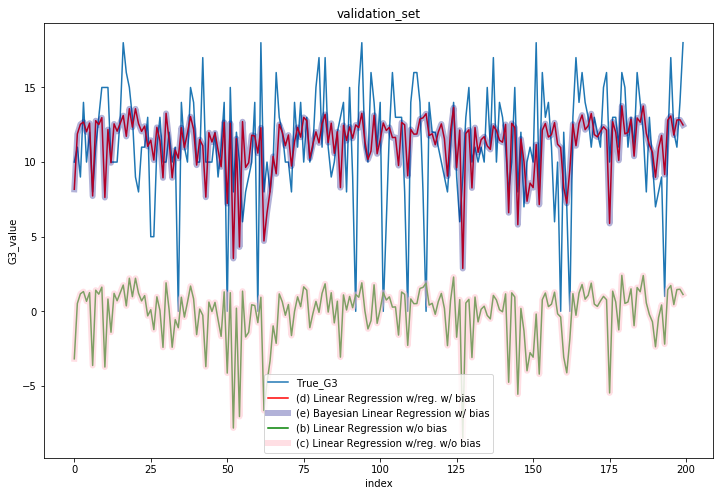

In [28]:
plt.figure(figsize=(12,8))
plt.plot(range(0,len(validation_set['ID'])),validation_set['G3'],label='True_G3')
plt.plot(range(0,len(validation_set['ID'])),y_pred_LR_re_bias,color='red',label='(d) Linear Regression w/reg. w/ bias')
plt.plot(range(0,len(validation_set['ID'])),y_pred_bay,color='navy',alpha=0.3,linewidth=6,label='(e) Bayesian Linear Regression w/ bias')
plt.plot(range(0,len(validation_set['ID'])),y_pred_LR,color='green',alpha=1,label='(b) Linear Regression w/o bias')
plt.plot(range(0,len(validation_set['ID'])),y_pred_LR_re_no_bias,color='pink',alpha=0.5,linewidth=6,label='(c) Linear Regression w/reg. w/o bias')
plt.xlabel('index')
plt.ylabel('G3_value')
plt.title('validation_set')
plt.legend()

In [ ]:
Please compare the RMSEs and predicted G3 values
in your report. Also, please explain mathematically why predicted G3 values are
closer to the ground truth for (d) and (e).

 ### (g) (10%) Apply the model from 1. (e) to test no G3.csv and save your results as StudentID 1.txt. You are       
 
 ###                  allowed to tune α.

In [29]:
alpha=np.linspace(0.001, 50, num=1000)

train_rmse=[]
val_rmse=[]

for i in range(0,len(alpha)):
    
    w,y_hat=Bayesian_LR(X_train_int,y_train,alpha[i])
    
    # training
    y_pred_bay_train=np.matmul(X_train_int,w)
    # RMSE
    train_rmse.append(RMSE(y_train,y_pred_bay_train))
  
    # validation
    y_pred_bay_val=np.matmul(X_val_int,w)
    # RMSE
    val_rmse.append(RMSE(y_val,y_pred_bay_val))

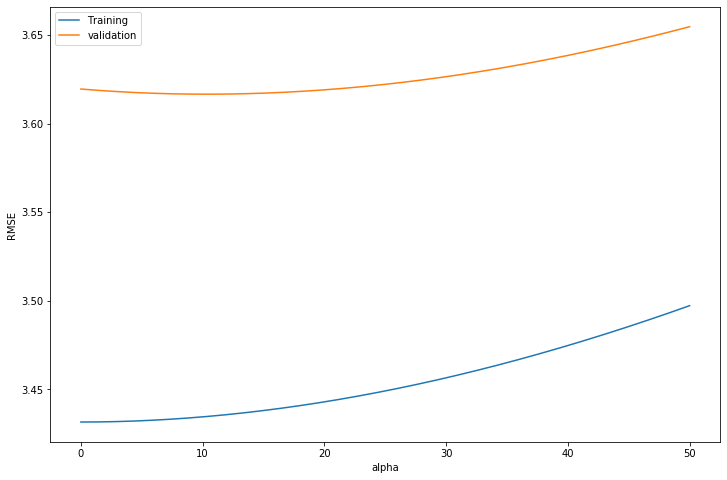

In [30]:
plt.figure(figsize=(12,8))
plt.plot(alpha,train_rmse,label='Training')
plt.plot(alpha,val_rmse,label='validation')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.legend()

In [31]:
# choose alpha 
alpha1=alpha[val_rmse.index(min(val_rmse))]
print(alpha1)
w,y_hat=Bayesian_LR(X_train_int,y_train,alpha1)

10.311104104104105


In [32]:
# test set
X_test=np.concatenate(([np.matrix(test_N[test_N.columns[col]]).T for col in range(1,len(test_N.columns))]),axis=1)
X_test_int=np.concatenate(((np.matrix(np.ones(X_test.shape[0])).T,X_test)),axis=1)

In [33]:
y_test_pred=np.asarray(np.matmul(X_test_int,w)).reshape(-1)
y_test_pred

array([11.7658214 , 11.53238099, 12.07611012, 12.14107207, 11.82886946,
       10.6090476 , 11.38565452, 13.45390075, 11.85313967,  9.86451509,
       12.69815522,  9.42080583, 11.90454596, 12.28416698, 10.68218635,
       12.35433229,  3.83488939, 13.58142356,  5.63958089, 13.07113724,
       11.52317128,  9.77260242, 10.20925333, 12.21917056, 11.36656154,
       11.59354976, 12.98492592, 12.03988172, 11.50757414,  8.72848126,
       11.12508044,  5.87788754, 12.12346259, 11.50567537, 11.85560677,
       12.46451662, 12.15800412, 12.89199836, 11.75098985, 13.15973581,
        4.88471356, 12.41319284, 11.58954855, 10.89804324])

In [35]:
outf = open(file="R10h41003.txt", mode="wt")  

for i in range(len(y_test_pred)):
    outf.write(str(1001+i)+"\t"+str(y_test_pred[i])+'\n')
outf.flush()                            
outf.close()

# 2. (20%) Census Income Data Set

#### (a) Try to do 1. (a)-(e) on Census Income Data Set (adult.data and adult.test, for more details, check https://archive.ics.uci.edu/ml/datasets/Census+Income). α is tunable. 

#### Predict target is the last column (>50K, ≤50K). Describe your finding.

# Read Data

In [36]:
con_var=['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
cate_var=['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
target=['income']

columns=['age', 'workclass', 'fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country']

# reading csv files
train2 =  pd.read_csv('adult.data', sep=",",names=columns+target,index_col=False)
print(train2.shape)
train2.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [37]:
test2 =  pd.read_csv('adult.test', sep=",",names=columns+target,index_col=False,skiprows=[0])
print(test2.shape)
test2.head()

(16281, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


# Transform category  columns to one-hot encoding vectors

In [38]:
train2=pd.concat([train2[target+con_var],pd.DataFrame(pd.get_dummies(train2[cate_var]))],axis=1) 
test2=pd.concat([test2[target+con_var],pd.DataFrame(pd.get_dummies(test2[cate_var]))],axis=1) 

# Split train.csv into training set (80%) and validation set (20%)

In [39]:
random.seed(121)
p=0.8
training_set2,validation_set2=train_valid_split(train2,p)

print(training_set2.shape)
print(validation_set2.shape)

(26048, 109)
(6513, 109)


# Normalization

In [40]:
tra_X_mean=training_set2[training_set2.columns[1:]].mean(axis=0) #選擇需要 normalized 的變數
tra_X_std=training_set2[training_set2.columns[1:]].std(axis=0)

In [41]:
test2['native-country_ Holand-Netherlands']=0
training_set_N2, validation_set_N2,test_N2=Normalization(training_set2,validation_set2,test2,tra_X_mean,tra_X_std)

In [59]:
# training set
X_train2=np.concatenate(([np.matrix(training_set_N2[training_set2.columns[col]]).T for col in range(1,len(training_set2.columns))]),axis=1)
#y_train2=np.matrix(training_set_N2[target])

In [60]:
X_train2

matrix([[ 0.03284782, -1.06731962,  1.13247016, ...,  0.34047602,
         -0.04385375, -0.02234522],
        [ 0.83762088, -1.01223523,  1.13247016, ...,  0.34047602,
         -0.04385375, -0.02234522],
        [-0.04031336,  0.24567558, -0.41727282, ...,  0.34047602,
         -0.04385375, -0.02234522],
        ...,
        [ 1.42291038, -0.3601672 , -0.41727282, ...,  0.34047602,
         -0.04385375, -0.02234522],
        [-1.21089236,  0.11111567, -0.41727282, ...,  0.34047602,
         -0.04385375, -0.02234522],
        [ 0.98394326,  0.93274287, -0.41727282, ...,  0.34047602,
         -0.04385375, -0.02234522]])